#  Gravitational Wave Data Analysis tutorial #1

This notebook describes basics about graivtational wave signals from compact binary coalescences (CBCs), gives some basics on signal processing in the Fourier domain as well as some tools to visualize the data, and finally presents a simplified example of matched filtering, allowing to recover the signal of GW150914 in real data.

We refer to the lectures and tutorials available at the GWOSC: [Gravitational-Wave Open Science Center (GWOSC)](https://www.gw-openscience.org).
    
[Click this link to view this tutorial in Google Colaboratory](https://colab.research.google.com/github/SylvainMarsat/gwda_tutorial/blob/main/tutorial_1.ipynb)

Author: Sylvain Marsat

Date: 2025-06-30

## Install

When running in Google Colab, uncomment and run the cell to install required packages:

In [ ]:
#! pip install numpy scipy h5py matplotlib ipython jupyterlab tqdm lalsuite gwpy

When running in Google Colab, uncomment and run the cell to download the required data:

In [ ]:
#! mkdir data
#! wget https://www.github.com/SylvainMarsat/gwda_tutorial/blob/main/data/H-H1_LOSC_4_V2-1126259446-32.hdf5 -P data/

UNTESTED - When running in Google Colab, uncomment and run the cell to install latex for matplotlib:

In [ ]:
#!apt install texlive-fonts-recommended texlive-fonts-extra cm-super dvipng

## Imports

In [1]:
import os, sys
import h5py, json
import copy
import numpy as np
import scipy
import astropy
import astropy.units as u
import matplotlib.pyplot as plt
# import matplotlib.mlab as mlab

import gwosc
import gwpy

import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio") # to silence a warning
import lal
import lalsimulation
import lalsimulation.gwsignal.core.waveform as wfm
from lalsimulation.gwsignal import gwsignal_get_waveform_generator

from tqdm import tqdm as tqdm

/Users/marsat/miniconda3/envs/odw/lib/python3.11/site-packages/gwpy/time/__init__.py:36: UserWarning: Wswiglal-redir-stdio:

SWIGLAL standard output/error redirection is enabled in IPython.
This may lead to performance penalties. To disable locally, use:

with lal.no_swig_redirect_standard_output_error():
    ...

To disable globally, use:

lal.swig_redirect_standard_output_error(False)

Note however that this will likely lead to error messages from
LAL functions being either misdirected or lost when called from
Jupyter notebooks.

To suppress this warning, use:

import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import lal

  from lal import LIGOTimeGPS


The pyseobnr package has failed to load, you will not be able to employ SEOBNRv5 approximants.


In [2]:
%matplotlib inline

## Definitions

In [3]:
colors = ["#4C72B0", "#C44E52", "#CCB974", "#55A868", "#8172B2", "#64B5CD", '#FFA500', '#A0522D']

rc_params = {'backend': 'ps',
            'axes.unicode_minus':False,
            'axes.grid':True,
            'lines.linewidth':1.,
            'grid.linestyle':':',
            'grid.linewidth':1.,
            'hist.bins':50,
            'axes.labelsize':16,
            'axes.titlesize':16,
            'xtick.labelsize':16,
            'ytick.labelsize':16,
            'legend.fontsize':16,
            'figure.dpi':100}
plt.rcParams.update(rc_params)

In [4]:
# Definitions for the windowing function -- function for vectorial argument
# In order to avoid overflows in the exponentials, we set the boundaries (di, df) so that anything below 10^-20 is considered zero
def window_planck(x, xi, xf, deltaxi, deltaxf):
    di = deltaxi/(20*np.log(10))
    df = deltaxf/(20*np.log(10))
    w = np.zeros(len(x), dtype=float)
    #
    mask = (x <= xi + di) | (x >= xf - df)
    w[mask] = 0.
    #
    mask = (xi + di < x) & (x < xi + deltaxi - di)
    xm = x[mask]
    w[mask] = 1./(1 + np.exp(deltaxi/(xm - xi) + deltaxi/(xm - (xi + deltaxi))))
    #
    mask = (xi + deltaxi - di <= x) & (x <= xf - deltaxf + df)
    w[mask] = 1.
    #
    mask = (xf - deltaxf + df < x) & (x < xf - df)
    xm = x[mask]
    w[mask] = 1./(1 + np.exp(-(deltaxf/(xm - (xf - deltaxf))) - deltaxf/(xm - xf)))
    #
    return w

In [5]:
def zeropad(times, data, extend=0):
    n = len(times)
    n_pad = 2**(int(np.ceil(np.log(n) / np.log(2))) + extend)
    dt = times[1] - times[0]
    times_pad = times[0] + dt * np.arange(n_pad)
    data_pad = np.zeros(n_pad, dtype=data.dtype)
    data_pad[:n] = data
    return times_pad, data_pad

In [6]:
def fft_positivef(times, data):
    n = len(times)
    deltat = times[1] - times[0]
    deltaf = 1./(n*deltat)
    # Fast Fourier Transform
    freqs = deltaf*np.arange(n)
    # BEWARE: due to the different convention for the sign of Fourier frequencies, we have to reverse the FFT output
    # Beware also that the FFT treats effectively the initial time as 0
    # BEWARE: in the reversion of the numpy-convention FFT output, we have to set aside the 0-frequency term
    data_fd = deltat * np.fft.fft(data)
    # Discarding information on negative frequencies - if real timeseries in input, no information loss as the deleted values are the conjugate
    data_fd = data_fd[:n//2+1]
    freqs = freqs[:n//2+1]
    # Coming back to the initial times
    tstart = times[0]
    fac_timeshift = np.exp(1j*2*np.pi*freqs*tstart)
    data_fd = data_fd * fac_timeshift
    return freqs, data_fd

In [7]:
def ifft_positivef(freqs, data, tstart=0., real=False):
    # Assumes n = N/2+1, with N length of data
    n = len(freqs)
    deltaf = freqs[1] - freqs[0]
    # Zero-pad to next power of 2, then 0-pad by factor 2 for the negative frequencies
    N = 2*(n - 1)
    # N_pad = 2**(int(np.ceil(np.log(N) / np.log(2))) + 1)
    freqs_pad = deltaf * np.arange(N)
    data_pad = np.zeros(N, dtype=data.dtype)
    data_pad[:n] = data
    # If data is FFT of real data, complete implicit f<0 values in the second half of the vector
    if real:
        data_pad[n:] = np.conj(data[1:n-1][::-1])
    # Factor to restore times
    fac_timeshift = np.exp(-1j*2*np.pi*freqs_pad*tstart)
    # Inverse FFT
    deltat = 1./(N*deltaf)
    data_td = 1./deltat * np.fft.ifft(fac_timeshift * data_pad)
    if real:
        data_td = np.real(data_td)
    # Rebuild times
    times = tstart + deltat * np.arange(N)
    return times, data_td

# Part I: visualizing CBC signals

## Basics of CBC signals

The frequency evolution at leading order, using the quadrupole formula for the emission of gravitational waves and the energy/flux balance equation, is:
$$ \dot{\phi}_{\rm orb} (t) = \omega(t) = \left[ \frac{256}{5c^5} (G \mathcal{M}_c)^{5/3} (t_c - t) \right]^{-3/8} $$
where $\mathcal{M}_c = (m_1 m_2)^{3/5}/(m_1+m_2)^{1/5}$ is the chirp mass, and $\phi_{\rm orb}$ is the orbital phase. This describes the chirp in frequency, far from the coalescence. The polarizations $h_+$, $h_\times$ are at the same order:
$$ h_+(t) = \frac{4 G \mathcal{M}_c}{R c^2} \left(\frac{G \mathcal{M}_c \omega}{c^3}\right)^{2/3} \frac{1 + \cos^2 \theta}{2} \cos \left[ 2 \phi_{\rm orb}(t) + \phi_0\right] $$
$$ h_\times(t) = \frac{4 G \mathcal{M}_c}{R c^2} \left(\frac{G \mathcal{M}_c \omega}{c^3}\right)^{2/3} \cos \theta \sin \left[ 2 \phi_{\rm orb}(t) + \phi_0\right] $$
where $\theta$ is the inclination, $R$ the distance to the source and $\phi_0$ a phase constant. In an expanding universe, the observed waveform remains of the same form, with the replacements $\mathcal{M}_c \rightarrow (1+z) \mathcal{M}_c$ where $z$ is the redshift and $R \rightarrow d_L$, the luminosity distance.

A useful decomposition of the signal is given in spin-weighted spherical harmonics:
$$ h_+ - i h_\times = \sum_{\ell \geq 2} \sum_{m=-\ell}^{\ell} {}_{-2}Y_{\ell m}(\theta, \phi) h_{\ell m}$$
The modes $h_{\ell m}$ summarize the radiation in all directions. The mode $h_{22}$ (or $h_{2,-2}$) is dominant.

The leading order amplitude of the mode $h_{22}$ is
$$ A_{22} = \frac{2 G \mathcal{M}_c}{R c^2} \left(\frac{G \mathcal{M}_c \omega}{c^3}\right)^{2/3} \sqrt{\frac{16\pi}{5}}$$

Each harmonic has a scaling with orbital phase as $h_{\ell m} \propto e^{-i m \phi_{\rm orb}}$. In the Fourier domain, if $\tilde{h}_{\ell m}(f) = \int dt\, e^{-2 i \pi f t} h_{\ell m}(t)$, we have approximately $\tilde{h}_{\ell m}(f) \simeq 0$ for $f > 0$ and $m > 0$. For non-precessing systems there is a symmetry relation between modes at $m>0$ and $m<0$. For positive frequencies, we only have to consider $h_{2,-2}$, $h_{2,-1}$ etc.

## Definitions

In [8]:
def gwsignal_dict_td(m1, m2, chi1, chi2, dist, inclination, f_min, f_ref, f_nyquist, phi_ref):

    python_dict = {'mass1' : m1*u.solMass,
                  'mass2' : m2*u.solMass,
                  'spin1x' : chi1[0]*u.dimensionless_unscaled,
                  'spin1y' : chi1[0]*u.dimensionless_unscaled,
                  'spin1z' : chi1[0]*u.dimensionless_unscaled,
                  'spin2x' : chi2[0]*u.dimensionless_unscaled,
                  'spin2y' : chi2[1]*u.dimensionless_unscaled,
                  'spin2z' : chi2[2]*u.dimensionless_unscaled,
                  'deltaT' : 1./(2*f_nyquist)*u.s,
                  'f22_start' : f_min*u.Hz,
                  'f22_ref': f_ref*u.Hz,
                  'phi_ref' : phi_ref*u.rad,
                  'distance' : dist*u.Mpc,
                  'inclination' : inclination*u.rad,
                  'eccentricity' : 0.*u.dimensionless_unscaled,
                  'longAscNodes' : 0.*u.rad,
                  'meanPerAno' : 0.*u.rad,
                    'condition': 0}
    return python_dict

def gwsignal_GenerateTDModes(m1, m2, chi1, chi2, dist=1e3, f_min=10., f_ref=10., f_nyquist=1024., phi_ref=0., approximant='IMRPhenomTPHM'):

    inclination = 0. # ignored for modes generation
    python_dict = gwsignal_dict_td(m1, m2, chi1, chi2, dist, inclination, f_min, f_ref, f_nyquist, phi_ref)

    gen = lalsimulation.gwsignal.gwsignal_get_waveform_generator(approximant)

    hlm_ts = wfm.GenerateTDModes(python_dict, gen)

    t = hlm_ts['time_array']
    modes = [k for k in hlm_ts.keys() if not k=='time_array']

    hlm = {}
    hlm['modes'] = modes
    hlm['t'] = np.asarray(t)
    for lm in modes:
        hlm[lm] = np.asarray(hlm_ts[lm])

    return hlm

def gwsignal_GenerateTDhphc(m1, m2, chi1, chi2, dist=1e3, inclination=np.pi/3, f_min=10., f_ref=10., f_nyquist=1024., phi_ref=0., approximant='IMRPhenomTPHM'):

    python_dict = gwsignal_dict_td(m1, m2, chi1, chi2, dist, inclination, f_min, f_ref, f_nyquist, phi_ref)

    gen = lalsimulation.gwsignal.gwsignal_get_waveform_generator(approximant)

    hp_ts, hc_ts = wfm.GenerateTDWaveform(python_dict, gen)

    return np.asarray(hp_ts.times), np.asarray(hp_ts.value), np.asarray(hc_ts.value)

In [9]:
def gwsignal_dict_fd(m1, m2, chi1, chi2, dist, inclination, f_min, f_max, f_ref, deltaf, phi_ref):

    python_dict = {'mass1' : m1*u.solMass,
                  'mass2' : m2*u.solMass,
                  'spin1x' : chi1[0]*u.dimensionless_unscaled,
                  'spin1y' : chi1[0]*u.dimensionless_unscaled,
                  'spin1z' : chi1[0]*u.dimensionless_unscaled,
                  'spin2x' : chi2[0]*u.dimensionless_unscaled,
                  'spin2y' : chi2[1]*u.dimensionless_unscaled,
                  'spin2z' : chi2[2]*u.dimensionless_unscaled,
                  'deltaF' : deltaf*u.Hz,
                  'f22_start' : f_min*u.Hz,
                  'f_max': f_max*u.Hz,
                  'f22_ref': f_ref*u.Hz,
                  'phi_ref' : phi_ref*u.rad,
                  'distance' : dist*u.Mpc,
                  'inclination' : inclination*u.rad,
                  'eccentricity' : 0.*u.dimensionless_unscaled,
                  'longAscNodes' : 0.*u.rad,
                  'meanPerAno' : 0.*u.rad,
                    'condition': 0}
    return python_dict


def gwsignal_GenerateFDModes(m1, m2, chi1, chi2, dist=1e3, f_min=10., f_max=512., f_ref=10., deltaf=0.125, phi_ref=0., approximant='IMRPhenomXPHM', positive_freqs=True):

    inclination = 0. # ignored for modes generation
    python_dict = gwsignal_dict_fd(m1, m2, chi1, chi2, dist, inclination, f_min, f_max, f_ref, deltaf, phi_ref)

    gen = lalsimulation.gwsignal.gwsignal_get_waveform_generator(approximant)

    hlm_fs = wfm.GenerateFDModes(python_dict, gen)

    f = hlm_fs['frequency_array']
    modes = [k for k in hlm_fs.keys() if not k=='frequency_array']

    hlm = {}
    hlm['modes'] = modes
    hlm['f'] = np.asarray(f)
    mask = np.ones_like(hlm['f'], dtype=bool)
    if positive_freqs:
        mask = (hlm['f'] >= 0)
    hlm['f'] = hlm['f'][mask]
    for lm in modes:
        hlm[lm] = np.asarray(hlm_fs[lm])[mask]

    return hlm

## Time-domain signals

In [10]:
hlm = gwsignal_GenerateTDModes(60., 30., [0., 0., 0.], [0., 0., 0.], f_min=15., f_ref=15.)

/Users/marsat/miniconda3/envs/odw/lib/python3.11/site-packages/lalsimulation/gwsignal/core/waveform.py:226: UserWarning: This code is currently UNREVIEWED, use with caution!
  warnings.warn("This code is currently UNREVIEWED, use with caution!")


In [11]:
hlm.keys()

dict_keys(['modes', 't', (2, -2), (2, -1), (2, 0), (2, 1), (2, 2), (3, -3), (3, -2), (3, -1), (3, 0), (3, 1), (3, 2), (3, 3), (4, -4), (4, -3), (4, -2), (4, -1), (4, 0), (4, 1), (4, 2), (4, 3), (4, 4), (5, -5), (5, -4), (5, -3), (5, -2), (5, -1), (5, 0), (5, 1), (5, 2), (5, 3), (5, 4), (5, 5)])

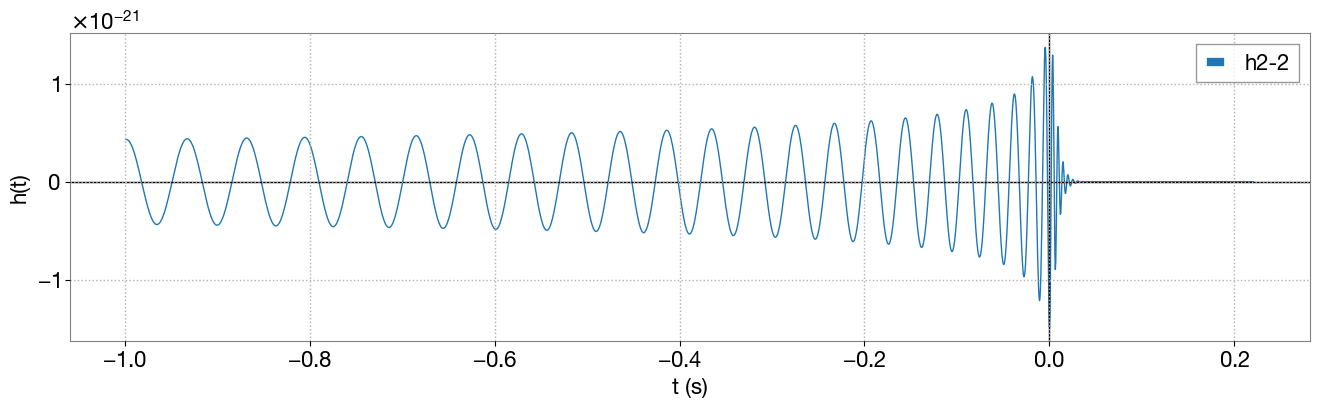

In [12]:
fig, ax = plt.subplots(1,1, figsize=[16,4])

ax.plot(hlm['t'], np.real(hlm[(2,-2)]) , label=r'h2-2')

ax.axhline(0., c='k')
ax.axvline(0., c='k')
ax.set_xlabel(r't (s)')
ax.set_ylabel(r'h(t)')
ax.legend(loc='best');

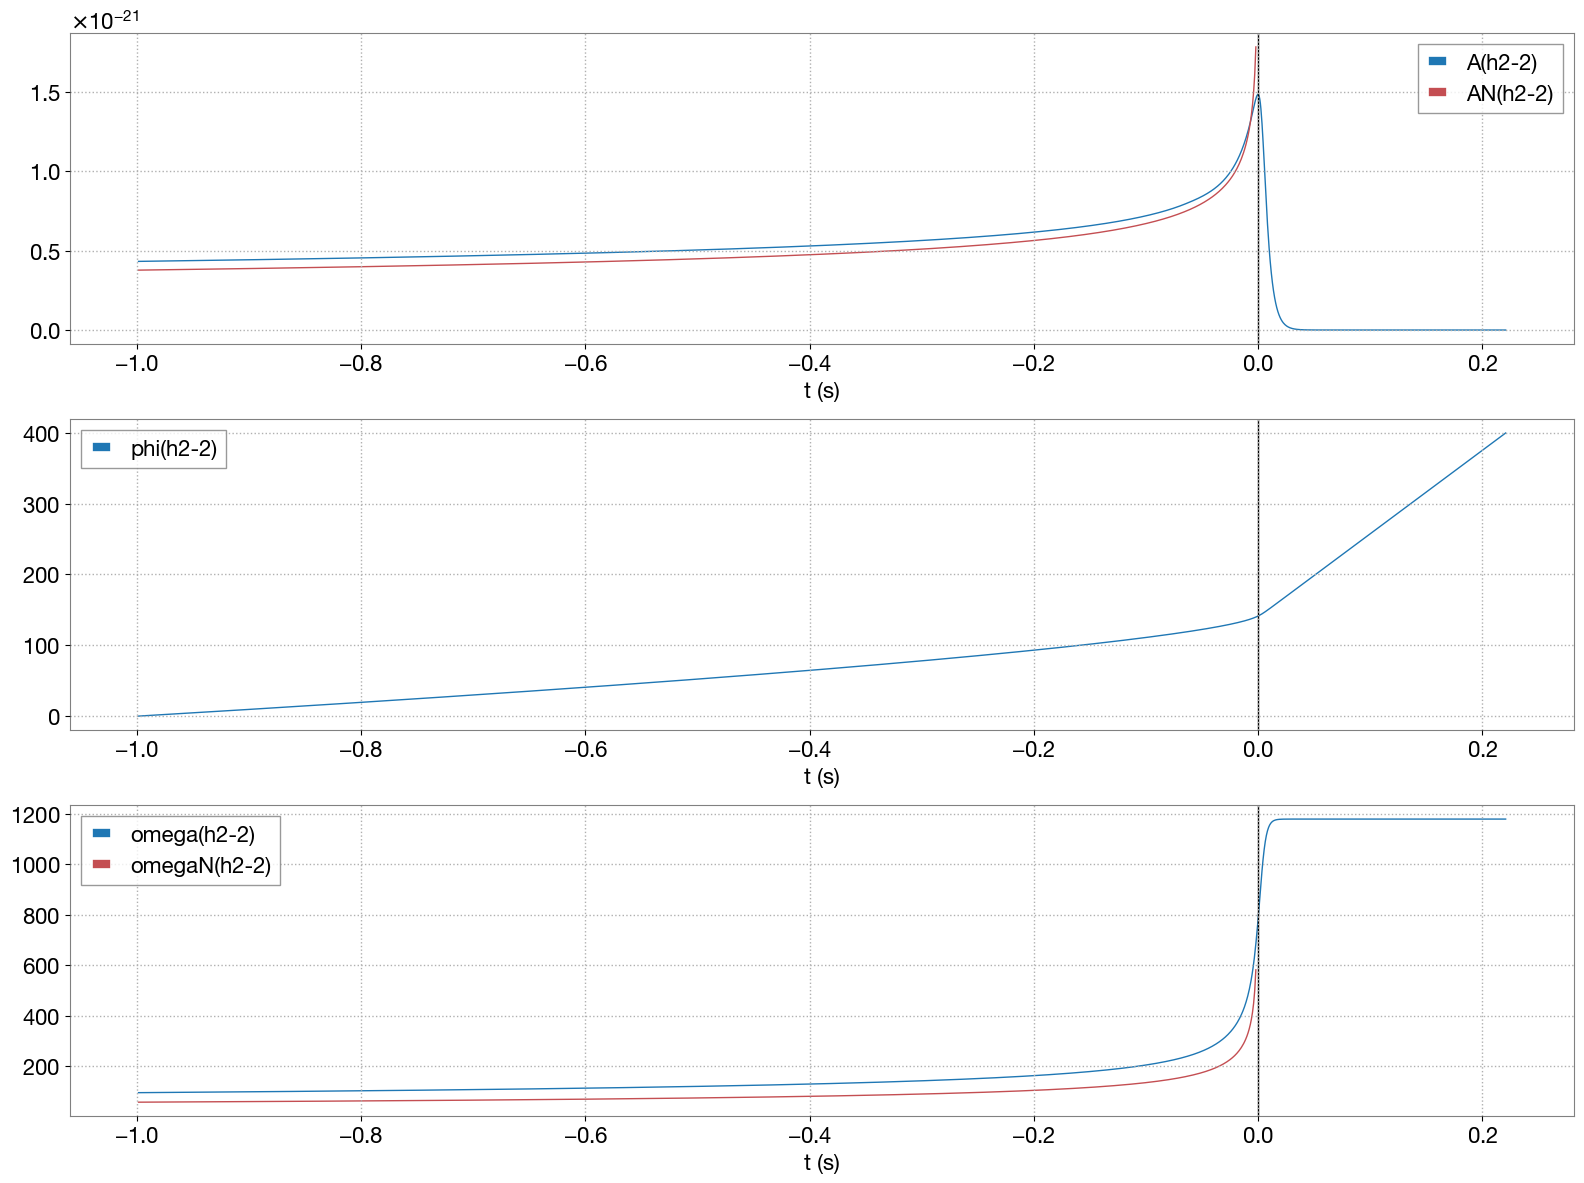

In [13]:
fig, axs = plt.subplots(3,1, figsize=[16,12])

amp = np.abs(hlm[(2,-2)])
phase = np.unwrap(np.angle(hlm[(2,-2)]))
omega = scipy.interpolate.InterpolatedUnivariateSpline(hlm['t'], phase)(hlm['t'], 1)

axs[0].plot(hlm['t'], amp, label=r'A(h2-2)')
axs[1].plot(hlm['t'], phase, label=r'phi(h2-2)')
axs[2].plot(hlm['t'], omega, label=r'omega(h2-2)')

# units
Msol_s = 4.925491025543576e-06 # GMsol/c^3
Msol_m = 1476.6250614046494 # GMsol/c^2
Mpc_m = 3.085677581491367e+22

m1, m2 = 40., 30.
Mchirp = (m1 * m2)**(3/5) / (m1 + m2)**(1/5)

tc = 0.
t_N = np.linspace(hlm['t'][0], tc - 0.002, 1000)
omega_N = (256/5 * (Mchirp*Msol_s)**(5/3) * (tc - t_N))**(-3/8)
amp_N = 2 * Mchirp*Msol_m / (1e3*Mpc_m) * (Mchirp*Msol_s*omega_N)**(2/3) * np.sqrt(16*np.pi/5)

axs[0].plot(t_N, amp_N, label=r'AN(h2-2)', c=colors[1])
axs[2].plot(t_N, omega_N, label=r'omegaN(h2-2)', c=colors[1])

for i in range(3):
    axs[i].axvline(0., c='k')
    axs[i].set_xlabel(r't (s)')
    axs[i].legend(loc='best');

fig.tight_layout()

/Users/marsat/miniconda3/envs/odw/lib/python3.11/site-packages/matplotlib/cbook.py:1709: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/Users/marsat/miniconda3/envs/odw/lib/python3.11/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


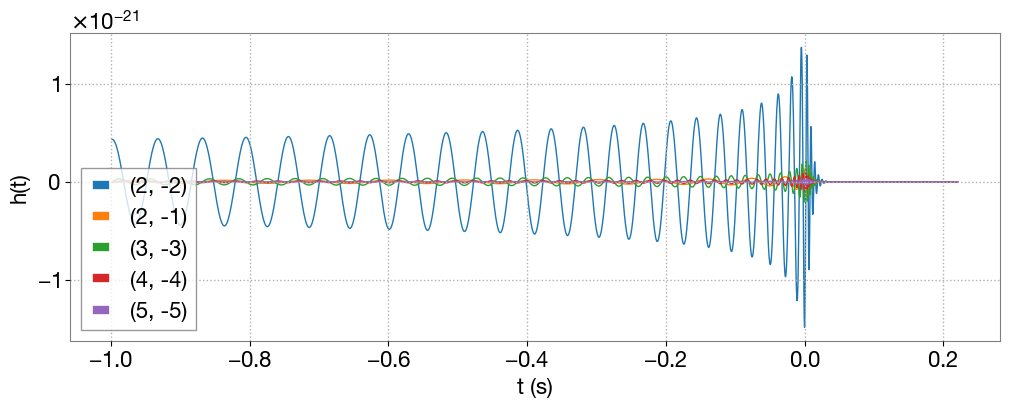

In [14]:
modes_plt = [(2,-2), (2,-1), (3,-3), (4,-4), (5,-5)]

fig, ax = plt.subplots(1,1, figsize=[12,4])

for lm in modes_plt:
    ax.plot(hlm['t'], hlm[lm], label=r''+str(lm))

ax.set_xlabel(r't (s)')
ax.set_ylabel(r'h(t)')
ax.legend(loc='best');

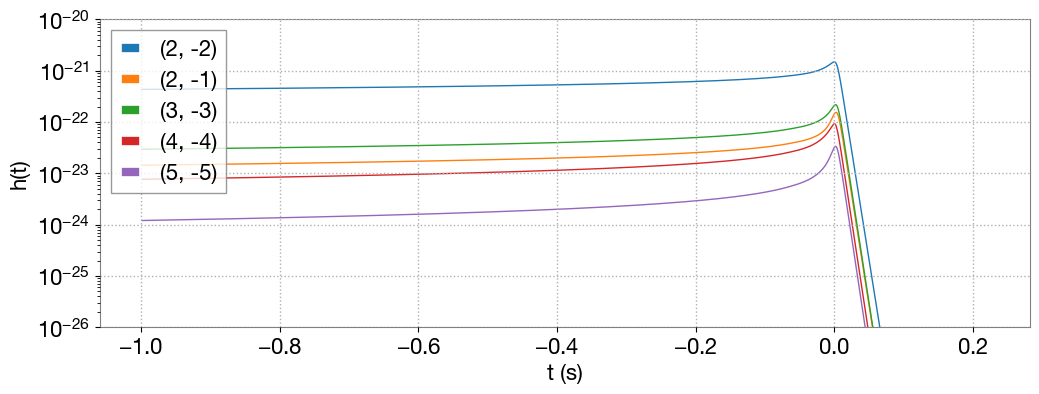

In [15]:
modes_plt = [(2,-2), (2,-1), (3,-3), (4,-4), (5,-5)]

fig, ax = plt.subplots(1,1, figsize=[12,4])

for lm in modes_plt:
    ax.plot(hlm['t'], np.abs(hlm[lm]) , label=r''+str(lm))

ax.set_yscale('log')
ax.set_ylim(1e-26, 1e-20)
ax.set_xlabel(r't (s)')
ax.set_ylabel(r'h(t)')
ax.legend(loc='upper left');

## Fourier-domain signals

In [16]:
hlm = gwsignal_GenerateFDModes(40., 30., [0., 0., 0.], [0., 0., 0.], f_min=15., f_max=1024., f_ref=15.)

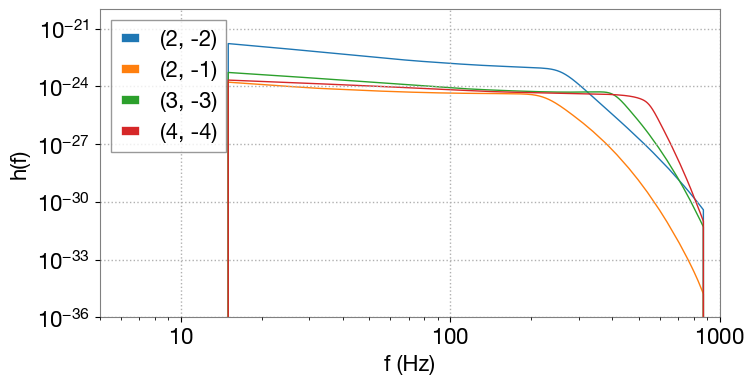

In [17]:
modes_plt = [(2,-2), (2,-1), (3,-3), (4,-4)]

fig, ax = plt.subplots(1,1, figsize=[8,4])

for lm in modes_plt:
    ax.loglog(hlm['f'], np.abs(hlm[lm]) , label=r''+str(lm))

ax.set_yscale('log')
ax.set_xlim(5., 1e3)
ax.set_ylim(1e-36, 1e-20)
ax.set_xlabel(r'f (Hz)')
ax.set_ylabel(r'h(f)')
ax.legend(loc='upper left');

## Qualitative trends

### Total mass

In [18]:
q = 2.
Mvals = [3., 5., 10., 20., 30., 40., 80., 120.]

t, hp, hc = gwsignal_GenerateTDhphc(60., 15., [0., 0., 0.], [0., 0., 0.], f_min=15., f_ref=15., inclination=np.pi/3)

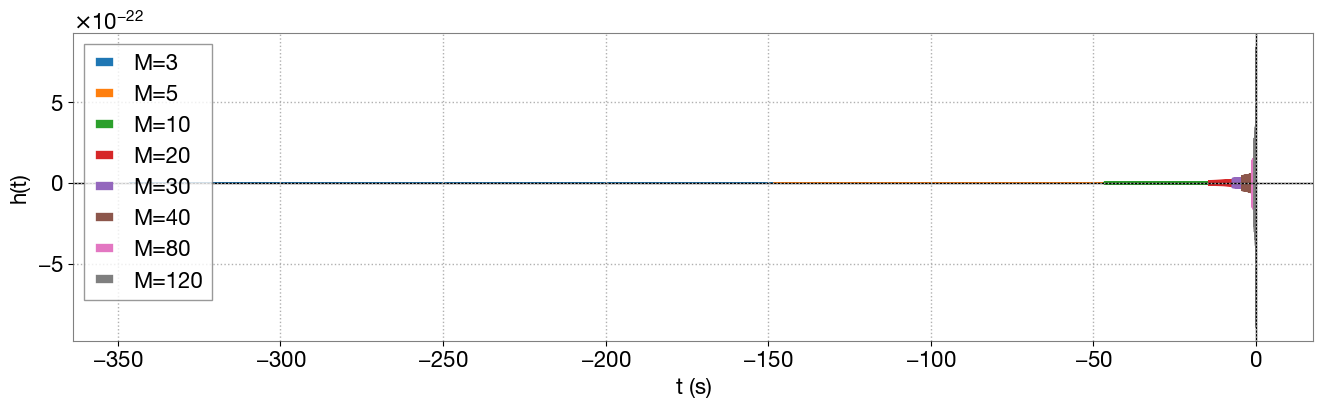

In [19]:
fig, ax = plt.subplots(1,1, figsize=[16,4])

q = 2.
Mvals = [3., 5., 10., 20., 30., 40., 80., 120.]
for M in Mvals:
    m1 = M * q / (1+q)
    m2 = M * 1 / (1+q)
    t, hp, hc = gwsignal_GenerateTDhphc(m1, m2, [0., 0., 0.], [0., 0., 0.], f_min=15., f_ref=15., inclination=np.pi/3)
    ax.plot(t, hp, label=r'M=' + str(int(M)))

ax.axhline(0., c='k')
ax.axvline(0., c='k')
ax.set_xlabel(r't (s)')
ax.set_ylabel(r'h(t)')
ax.legend(loc='best');

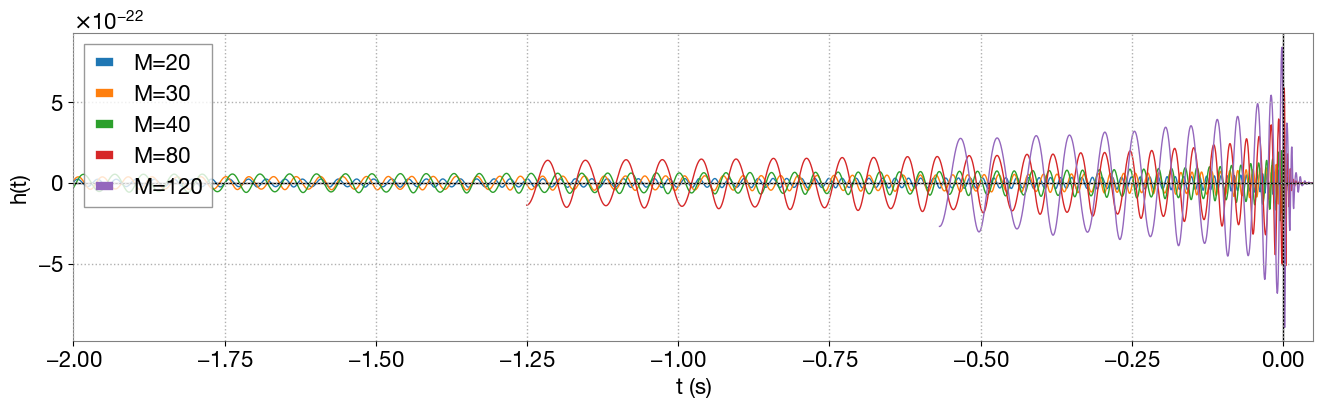

In [20]:
fig, ax = plt.subplots(1,1, figsize=[16,4])

q = 2.
Mvals = [20., 30., 40., 80., 120.]
for M in Mvals:
    m1 = M * q / (1+q)
    m2 = M * 1 / (1+q)
    t, hp, hc = gwsignal_GenerateTDhphc(m1, m2, [0., 0., 0.], [0., 0., 0.], f_min=15., f_ref=15., inclination=np.pi/3)
    ax.plot(t, hp, label=r'M=' + str(int(M)))

ax.set_xlim(-2, 0.05)
ax.axhline(0., c='k')
ax.axvline(0., c='k')
ax.set_xlabel(r't (s)')
ax.set_ylabel(r'h(t)')
ax.legend(loc='best');

### Inclination

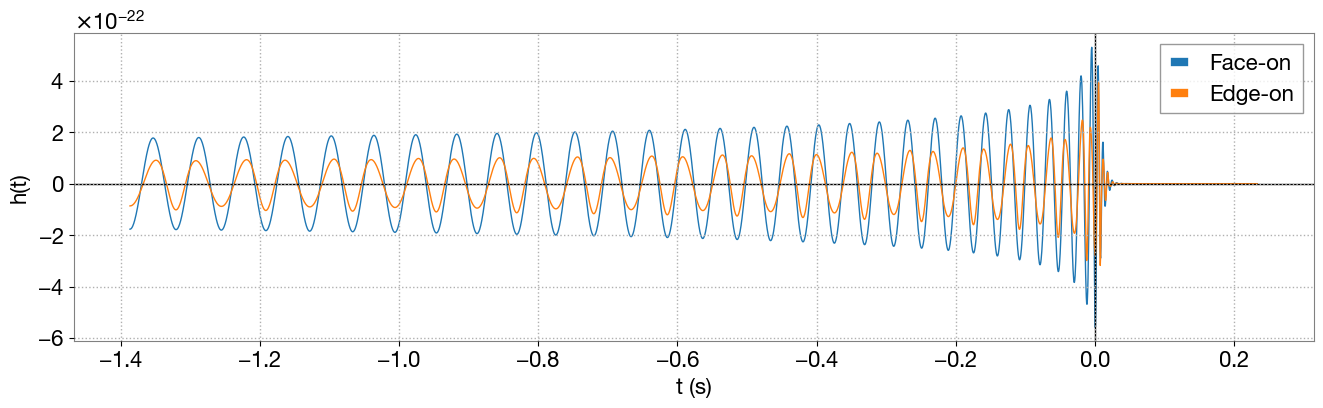

In [21]:
fig, ax = plt.subplots(1,1, figsize=[16,4])

t, hp, hc = gwsignal_GenerateTDhphc(80., 15., [0., 0., 0.], [0., 0., 0.], f_min=15., f_ref=15., inclination=0)
ax.plot(t, hp , label=r'Face-on')
t, hp, hc = gwsignal_GenerateTDhphc(80., 15., [0., 0., 0.], [0., 0., 0.], f_min=15., f_ref=15., inclination=np.pi/2)
ax.plot(t, hp , label=r'Edge-on')

ax.axhline(0., c='k')
ax.axvline(0., c='k')
ax.set_xlabel(r't (s)')
ax.set_ylabel(r'h(t)')
ax.legend(loc='best');

### Spin precession

When spins are misaligned, they can induce a precession of the orbital plane. In a moving frame (the precessing frame) following the plane of the orbits, the waveform retains (approximately) its harmonics structure; but for a fixed distant observer, modes appear to be modulated as the orbits precesses.

This is very well illustrated in the following videos by Vijay Varma:
[Binary Black Hole Explorer](https://vijayvarma392.github.io/binaryBHexp/)

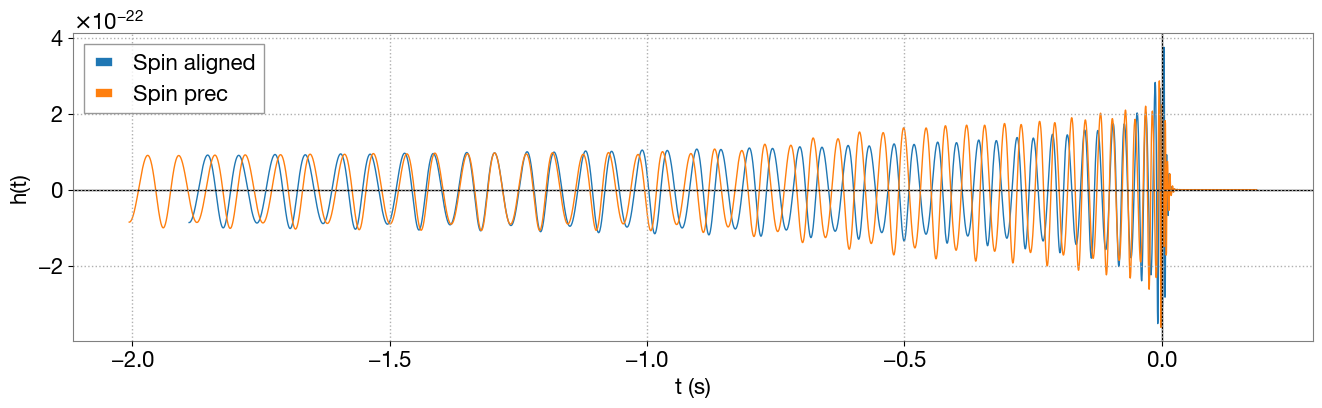

In [22]:
fig, ax = plt.subplots(1,1, figsize=[16,4])

t, hp, hc = gwsignal_GenerateTDhphc(60., 15., [0., 0., 0.], [0., 0., 0.], f_min=15., f_ref=15., inclination=np.pi/3)
ax.plot(t, hp , label=r'Spin aligned')
t, hp, hc = gwsignal_GenerateTDhphc(60., 15., [0.2, 0.8, 0.], [-0.7, 0.5, 0.], f_min=15., f_ref=15., inclination=np.pi/3)
ax.plot(t, hp , label=r'Spin prec')

ax.axhline(0., c='k')
ax.axvline(0., c='k')
ax.set_xlabel(r't (s)')
ax.set_ylabel(r'h(t)')
ax.legend(loc='best');

## FFT/IFFT and conditioning

$$ p(\theta | d, M_s) = \frac{\mathcal{L}(d| \theta, M_s) \;\pi(\theta | M_s)}{\mathcal{Z}(d | M_s)} $$

In [23]:
hlm = gwsignal_GenerateTDModes(40., 30., [0., 0., 0.], [0., 0., 0.], f_min=15., f_ref=15.)
t, hp, hc = gwsignal_GenerateTDhphc(40., 30., [0., 0., 0.], [0., 0., 0.], f_min=15., f_ref=15.)

In [24]:
fft_h2m2_test = np.fft.fft(hlm[(2,-2)])
fft_hp_test = np.fft.fft(hp)

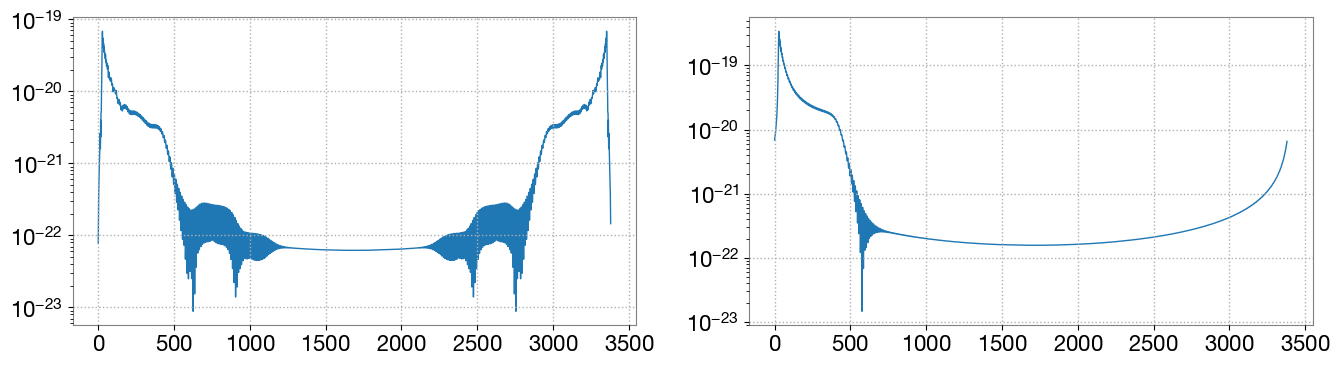

In [25]:
fig, axs = plt.subplots(1,2, figsize=[16,4])

axs[0].plot(np.abs(fft_hp_test), label=r'FFT(hplus)')
axs[1].plot(np.abs(fft_h2m2_test), label=r'FFT(h2-2)')

# ax.set_xlim(2., 800.)
# axs[1].set_xscale('log')
for i in range(2):
    axs[i].set_yscale('log')

The raw FFT displays the Gibbs phenomenon: sharp edges lead to spectral leakage, visible here as oscillatory features in the signal's amplitude.

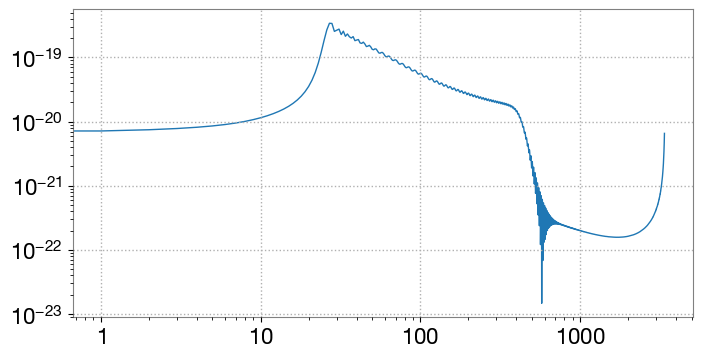

In [26]:
fig, ax = plt.subplots(1,1, figsize=[8,4])

ax.plot(np.abs(fft_h2m2_test), label=r'FFT(h2-2)')

ax.set_xscale('log')
ax.set_yscale('log')

We will apply a smooth window to the data, tapering the edges.
Syntax: `window_planck(t, tstart, tend, deltat_start, deltat_end)` is 0 outside of `[tstart, tend]` and goes from 0 to 1 on `[tstart, tstart + deltat_start]`, and back from 1 to 0 on `[tend - deltat_end, tend]`

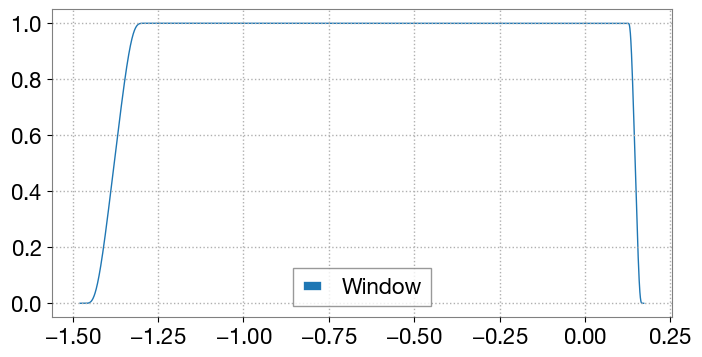

In [27]:
w = window_planck(hlm['t'], hlm['t'][0], hlm['t'][-1], 0.2, 0.05)

fig, ax = plt.subplots(1,1, figsize=[8,4])
ax.plot(hlm['t'], w, label=r'Window')
ax.legend()

In [28]:
w = window_planck(hlm['t'], hlm['t'][0], hlm['t'][-1], 0.2, 0.05)

t_pad, h2m2_pad = zeropad(hlm['t'], hlm[(2,-2)])
t_pad, h2m2_wpad = zeropad(hlm['t'], w * hlm[(2,-2)])
f, h2m2_fd = fft_positivef(t_pad, h2m2_pad)
f, h2m2w_fd = fft_positivef(t_pad, h2m2_wpad)

In [29]:
h2m2_wpad.shape, hlm[(2,-2)].shape

((4096,), (3381,))

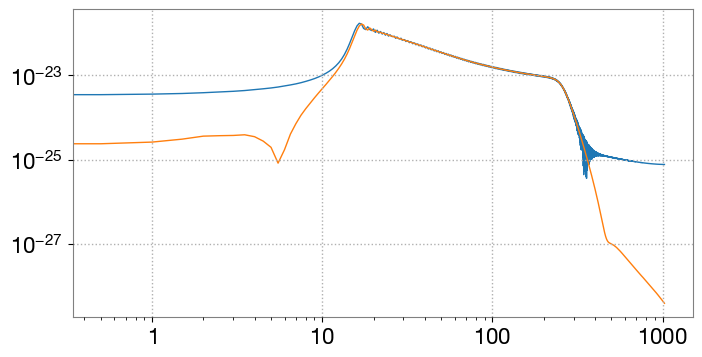

In [30]:
fig, ax = plt.subplots(1,1, figsize=[8,4])

ax.plot(f, np.abs(h2m2_fd), label=r'')
ax.plot(f, np.abs(h2m2w_fd), label=r'')

# ax.set_xlim(2., 800.)
ax.set_xscale('log')
ax.set_yscale('log')

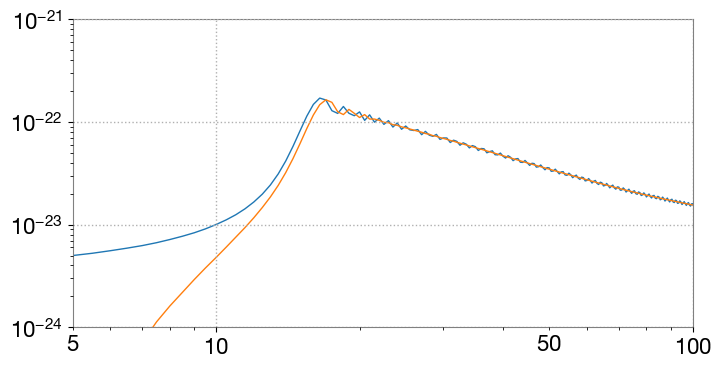

In [31]:
fig, ax = plt.subplots(1,1, figsize=[8,4])

ax.plot(f, np.abs(h2m2_fd), label=r'')
ax.plot(f, np.abs(h2m2w_fd), label=r'')

ax.set_xlim(5., 100.)
ax.set_ylim(1e-24, 1e-21)
ax.set_xscale('log')
ax.set_yscale('log')

In [32]:
f, h2m2w_fd = fft_positivef(t_pad, h2m2_wpad)

In [33]:
t_ifft, h2m2w_ifft = ifft_positivef(f, h2m2w_fd, tstart=t_pad[0], real=False)

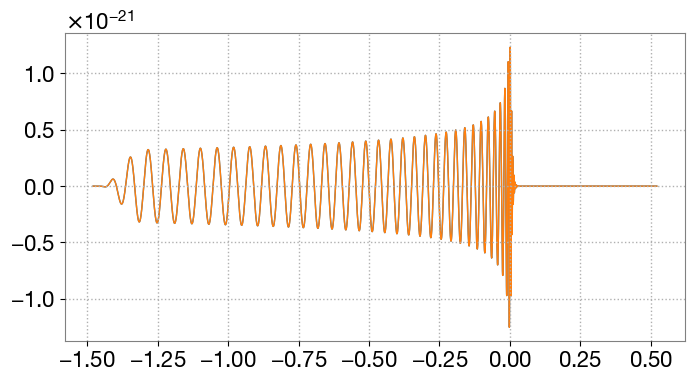

In [34]:
fig, ax = plt.subplots(1,1, figsize=[8,4])

ax.plot(t_ifft, np.real(h2m2w_ifft), label=r'')
ax.plot(t_pad, np.real(h2m2_wpad), label=r'')

# Part II: visualizing data

## Load data with gwosc and gwpy

In [35]:
from gwosc import datasets
from gwosc.datasets import find_datasets
from gwosc.datasets import event_gps

from gwpy.timeseries import TimeSeries

In [36]:
#-- List all available catalogs
print("List of available catalogs")
print(find_datasets(type="catalog"))

List of available catalogs
['GWTC', 'GWTC-1-confident', 'GWTC-1-marginal', 'GWTC-2', 'GWTC-2.1-auxiliary', 'GWTC-2.1-confident', 'GWTC-2.1-marginal', 'GWTC-3-confident', 'GWTC-3-marginal', 'IAS-O3a', 'Initial_LIGO_Virgo', 'O1_O2-Preliminary', 'O3_Discovery_Papers', 'O3_IMBH_marginal', 'O4_Discovery_Papers']


In [37]:
GWTC1_confident_events = datasets.find_datasets(type='events', catalog='GWTC-1-confident')
GWTC2_confident_events = datasets.find_datasets(type='events', catalog='GWTC-2.1-confident')
GWTC3_confident_events = datasets.find_datasets(type='events', catalog='GWTC-3-confident')

len(GWTC1_confident_events), len(GWTC2_confident_events), len(GWTC3_confident_events)

(11, 44, 35)

In [38]:
GWTC1_confident_events

['GW150914-v3',
 'GW151012-v3',
 'GW151226-v2',
 'GW170104-v2',
 'GW170608-v3',
 'GW170729-v1',
 'GW170809-v1',
 'GW170814-v3',
 'GW170817-v3',
 'GW170818-v1',
 'GW170823-v1']

### GW150914

In [39]:
t_gps = event_gps('GW150914')
print(t_gps)

1126259462.4


In [40]:
H1_data = TimeSeries.read('./data/GW150914/H-H1_GWOSC_4KHZ_R1-1126259447-32.hdf5', format="hdf5.gwosc")
L1_data = TimeSeries.read('./data/GW150914/L-L1_GWOSC_4KHZ_R1-1126259447-32.hdf5', format="hdf5.gwosc")

In [599]:
# segment = (int(gps) - 5, int(gps) + 5)
# H1_data = TimeSeries.fetch_open_data('H1', *segment, verbose=True, cache=True)
# L1_data = TimeSeries.fetch_open_data('L1', *segment, verbose=True, cache=True)

Fetched 1 URLs from gwosc.org for [1187008877 .. 1187008887))
Reading data... [Done]
Fetched 1 URLs from gwosc.org for [1187008877 .. 1187008887))
Reading data... [Done]


## Strain data

In [25]:
H1_data?

Type:        TimeSeries
String form:
TimeSeries([9.06730891e-21, 2.01178871e-20, 3.71290472e-20, ...,
           5.32101440e-20, 4.74 <...> 26259447.0 s,
           dt: 0.000244140625 s,
           name: Strain,
           channel: None)
Length:      131072
File:        ~/miniconda3/envs/odw/lib/python3.11/site-packages/gwpy/timeseries/timeseries.py
Docstring:  
A time-domain data array.

Parameters
----------
value : array-like
    input data array

unit : `~astropy.units.Unit`, optional
    physical unit of these data

t0 : `~gwpy.time.LIGOTimeGPS`, `float`, `str`, optional
    GPS epoch associated with these data,
    any input parsable by `~gwpy.time.to_gps` is fine

dt : `float`, `~astropy.units.Quantity`, optional
    time between successive samples (seconds), can also be given inversely
    via `sample_rate`

sample_rate : `float`, `~astropy.units.Quantity`, optional
    the rate of samples per second (Hertz), can also be given inversely
    via `dt`

times : `array-like`
    th

In [41]:
times = np.asarray(H1_data.times).copy()
# New origin of times: middle of our data interval
t_center = times[len(times)//2]
times -= t_center
tevent = t_gps - t_center
strain_H1 = np.asarray(H1_data).copy()
strain_L1 = np.asarray(L1_data).copy() + 1e-18 # Strain is shifted by a constant, unknown why

dt = H1_data.dt.value
fs = 1./dt
dt, fs, len(times)

(0.000244140625, 4096.0, 131072)

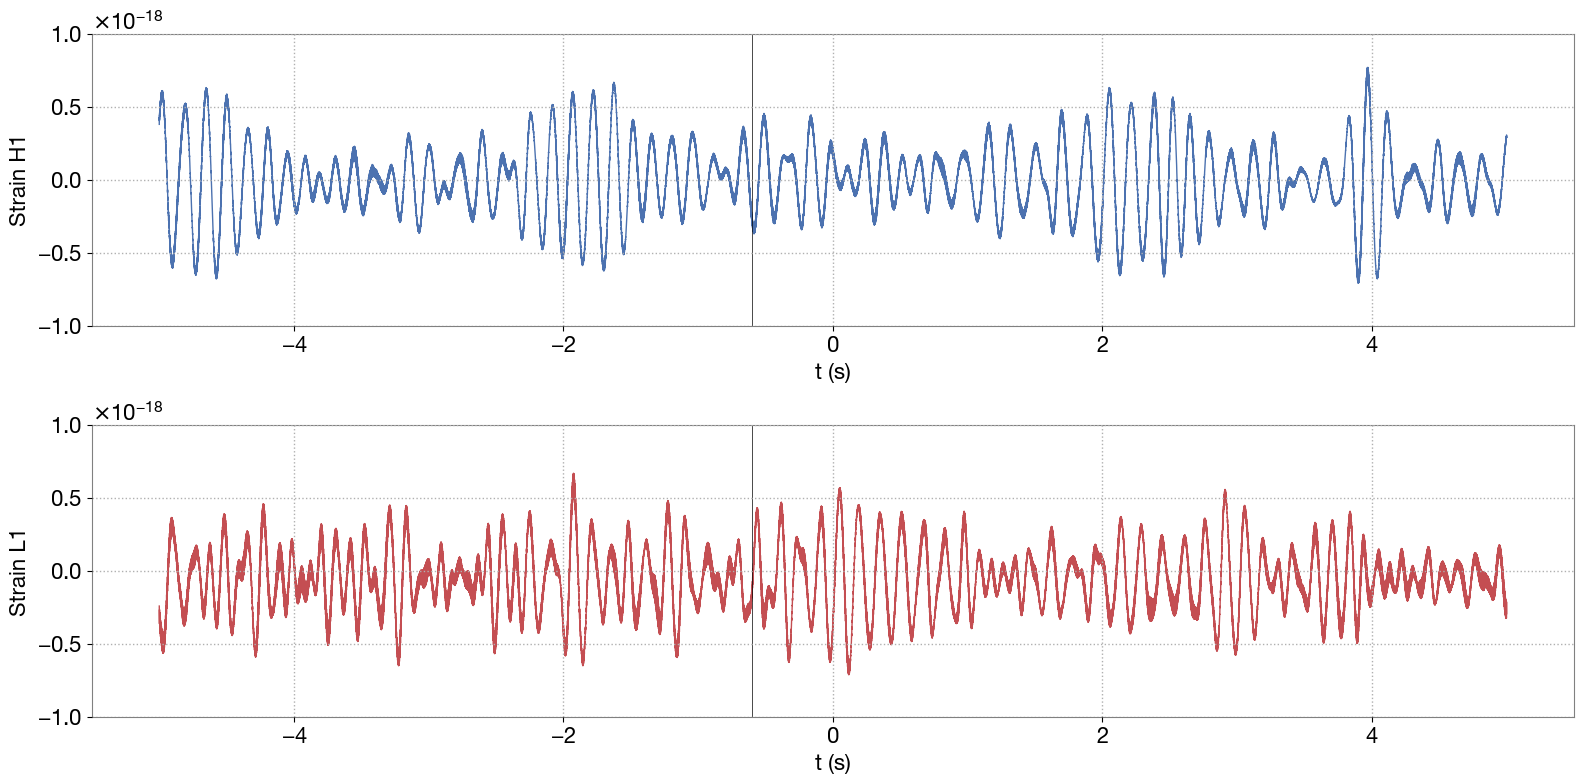

In [42]:
deltat = 5
mask = (-deltat <= times) & (times <= deltat)
ylim = [-1e-18, 1e-18]

fig, axs = plt.subplots(2,1, figsize=[16,8])
axs[0].plot(times[mask], strain_H1[mask], c=colors[0])
axs[1].plot(times[mask], strain_L1[mask], c=colors[1])

axs[0].set_ylabel(r'Strain H1')
axs[1].set_ylabel(r'Strain L1')
for i in range(2):
    axs[i].set_ylim(ylim)
    axs[i].set_xlabel(r't (s)')
    axs[i].axvline(tevent, c='k', lw=0.5)

fig.tight_layout()

## Evaluate PSD

In [8]:
scipy.signal.welch?

Signature:
scipy.signal.welch(
    x,
    fs=1.0,
    window='hann',
    nperseg=None,
    noverlap=None,
    nfft=None,
    detrend='constant',
    return_onesided=True,
    scaling='density',
    axis=-1,
    average='mean',
)
Docstring:
Estimate power spectral density using Welch's method.

Welch's method [1]_ computes an estimate of the power spectral
density by dividing the data into overlapping segments, computing a
modified periodogram for each segment and averaging the
periodograms.

Parameters
----------
x : array_like
    Time series of measurement values
fs : float, optional
    Sampling frequency of the `x` time series. Defaults to 1.0.
window : str or tuple or array_like, optional
    Desired window to use. If `window` is a string or tuple, it is
    passed to `get_window` to generate the window values, which are
    DFT-even by default. See `get_window` for a list of windows and
    required parameters. If `window` is array_like it will be used
    directly as the window 

In [43]:
freqs_psd, psd_H1 = scipy.signal.welch(strain_H1, fs,  window='hann', nperseg=16384, scaling='density')
freqs_psd, psd_L1 = scipy.signal.welch(strain_L1, fs,  window='hann', nperseg=16384, scaling='density')

# We will use interpolations of the ASDs computed above for whitening:
psd_H1_interp = scipy.interpolate.interp1d(freqs_psd, psd_H1)
psd_L1_interp = scipy.interpolate.interp1d(freqs_psd, psd_L1)

In [44]:
psd_H1.shape, freqs_psd[1] - freqs_psd[0]

((8193,), 0.25)

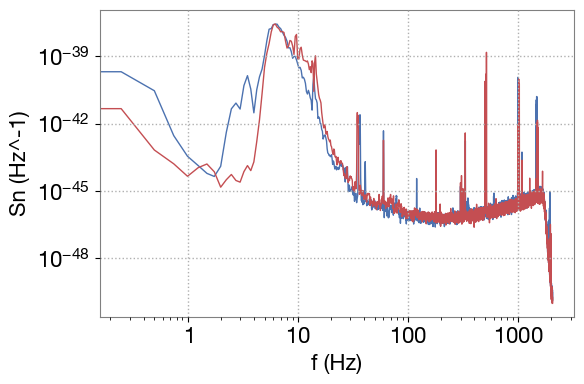

In [45]:
fig, ax = plt.subplots(1,1, figsize=[6,4])
ax.loglog(freqs_psd, psd_H1, c=colors[0], lw=1)
ax.loglog(freqs_psd, psd_L1, c=colors[1], lw=1)

# ax.set_xlim([5., 2048.])
ax.set_xlabel(r'f (Hz)')
ax.set_ylabel(r'Sn (Hz^-1)')

fig.tight_layout()

In [46]:
freqs_psd_lowres, psd_H1_lowres = scipy.signal.welch(strain_H1, fs,  window='hann', nperseg=2048, scaling='density')
freqs_psd_lowres, psd_L1_lowres = scipy.signal.welch(strain_L1, fs,  window='hann', nperseg=2048, scaling='density')

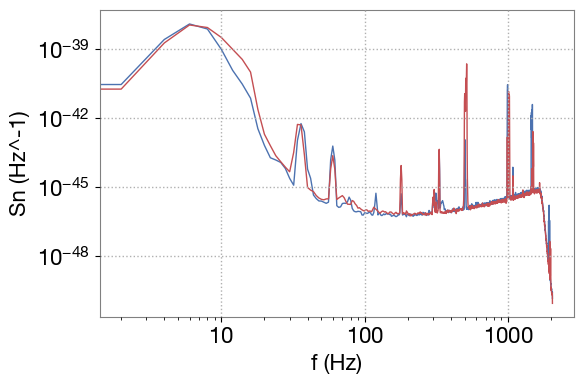

In [48]:
fig, ax = plt.subplots(1,1, figsize=[6,4])
ax.loglog(freqs_psd_lowres, psd_H1_lowres, c=colors[0], lw=1)
ax.loglog(freqs_psd_lowres, psd_L1_lowres, c=colors[1], lw=1)

# ax.set_xlim([5., 2048.])
ax.set_xlabel(r'f (Hz)')
ax.set_ylabel(r'Sn (Hz^-1)')

fig.tight_layout()

## Data visualization: tapering, band-passing, whitening, spectrogram

In [49]:
# Data selected to be +-2s around the event
# _d for 'data' that we are going to actually use

# n = 2**np.round(np.log2(4. / dt))
n = len(times)
# mask_d = ( -n//2*dt <= time) & (time < n//2*dt)
mask_d = np.ones(n, dtype=bool)
times_d = times[mask_d]
strain_H1_d = strain_H1[mask_d]
strain_L1_d = strain_L1[mask_d]

n, n*dt, len(times_d), [times_d[0], times_d[-1]]

(131072, 32.0, 131072, [-16.0, 15.999755859375])

In [50]:
# Tapering data at both ends
# w = pytools.window_planck_vec(time_d, time_d[0], time_d[-1], 0.5, 0.5)
w = window_planck(times_d, times_d[0], times_d[-1], 2., 2.)
strain_H1_tap = w * strain_H1_d
strain_L1_tap = w * strain_L1_d

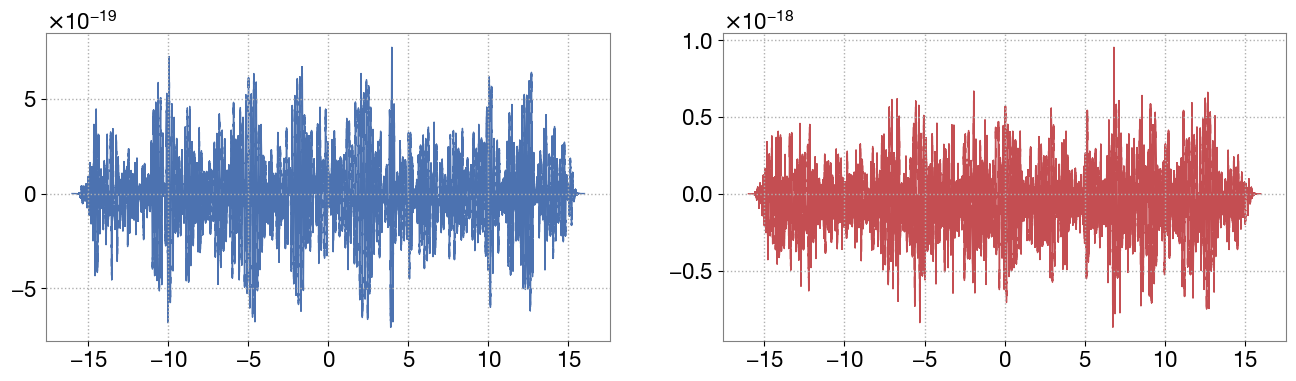

In [51]:
fig, axs = plt.subplots(1,2, figsize=[16,4])
axs[0].plot(times_d, strain_H1_tap, c=colors[0])
axs[1].plot(times_d, strain_L1_tap, c=colors[1])

In [52]:
# Data FD
f_d, strain_H1_fd = fft_positivef(times_d, strain_H1_tap)
f_d, strain_L1_fd = fft_positivef(times_d, strain_L1_tap)

df = f_d[1] - f_d[0]
df

0.03125

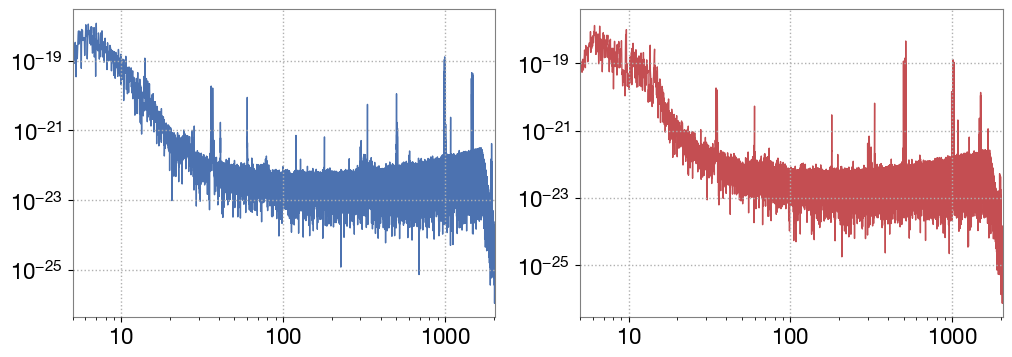

In [53]:
fig, axs = plt.subplots(1,2, figsize=[12,4])
axs[0].loglog(f_d, np.abs(strain_H1_fd), c=colors[0])
axs[1].loglog(f_d, np.abs(strain_L1_fd), c=colors[1])

for i in range(2):
    axs[i].set_xlim([5., 2048.])

In [55]:
# Data band-passed (no whitening)

w_bp = window_planck(f_d, 10., 512., 10., 64.)

strain_H1_fd_bp = w_bp * strain_H1_fd
strain_L1_fd_bp = w_bp * strain_L1_fd

_, strain_H1_td_bp = ifft_positivef(f_d, strain_H1_fd_bp, real=True, tstart=times_d[0])
_, strain_L1_td_bp = ifft_positivef(f_d, strain_L1_fd_bp, real=True, tstart=times_d[0])

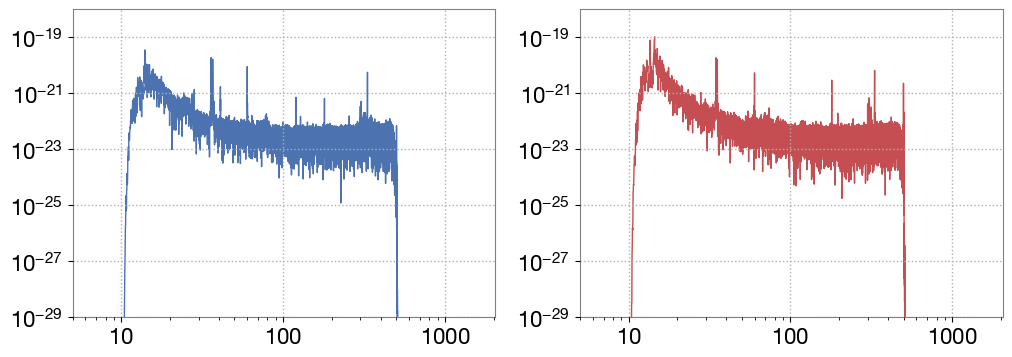

In [56]:
fig, axs = plt.subplots(1,2, figsize=[12,4])
axs[0].loglog(f_d, np.abs(strain_H1_fd_bp), c=colors[0])
axs[1].loglog(f_d, np.abs(strain_L1_fd_bp), c=colors[1])

for i in range(2):
    axs[i].set_xlim([5., 2048.])
    axs[i].set_ylim([1e-29, 1e-18])

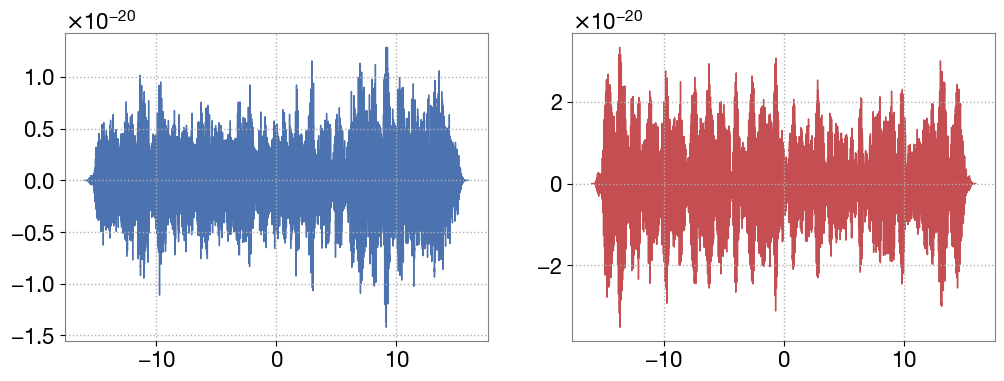

In [57]:
fig, axs = plt.subplots(1,2, figsize=[12,4])
axs[0].plot(times_d, strain_H1_td_bp, c=colors[0])
axs[1].plot(times_d, strain_L1_td_bp, c=colors[1])

In [59]:
# Data whitened after band-passing

w_bp = window_planck(f_d, 10., 512., 10., 64.)

strain_H1_fd_wbp = w_bp * np.sqrt(2*df / psd_H1_interp(f_d)) * strain_H1_fd
strain_L1_fd_wbp = w_bp * np.sqrt(2*df / psd_L1_interp(f_d)) * strain_L1_fd

_, strain_H1_td_wbp = ifft_positivef(f_d, strain_H1_fd_wbp, real=True, tstart=times_d[0])
_, strain_L1_td_wbp = ifft_positivef(f_d, strain_L1_fd_wbp, real=True, tstart=times_d[0])

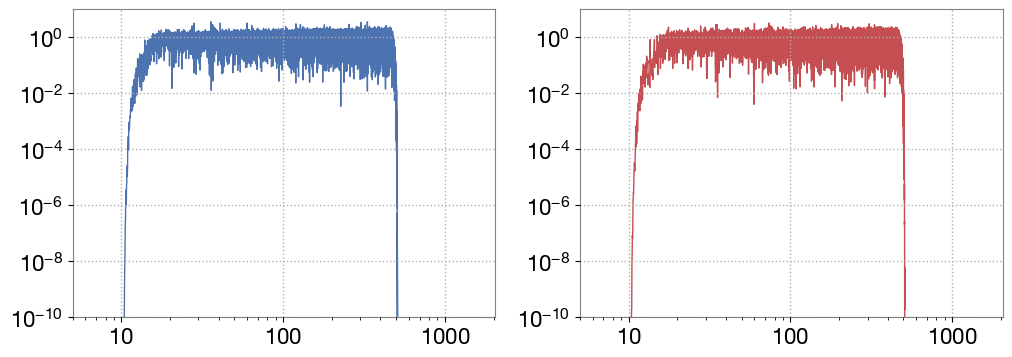

In [60]:
fig, axs = plt.subplots(1,2, figsize=[12,4])
axs[0].loglog(f_d, np.abs(strain_H1_fd_wbp), c=colors[0])
axs[1].loglog(f_d, np.abs(strain_L1_fd_wbp), c=colors[1])

for i in range(2):
    axs[i].set_xlim([5., 2048.])
    axs[i].set_ylim([1e-10, 1e1])

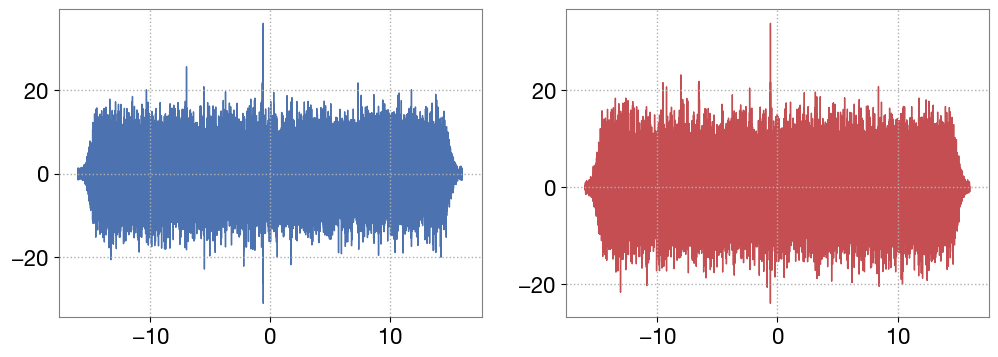

In [61]:
fig, axs = plt.subplots(1,2, figsize=[12,4])
axs[0].plot(times_d, strain_H1_td_wbp, c=colors[0])
axs[1].plot(times_d, strain_L1_td_wbp, c=colors[1])

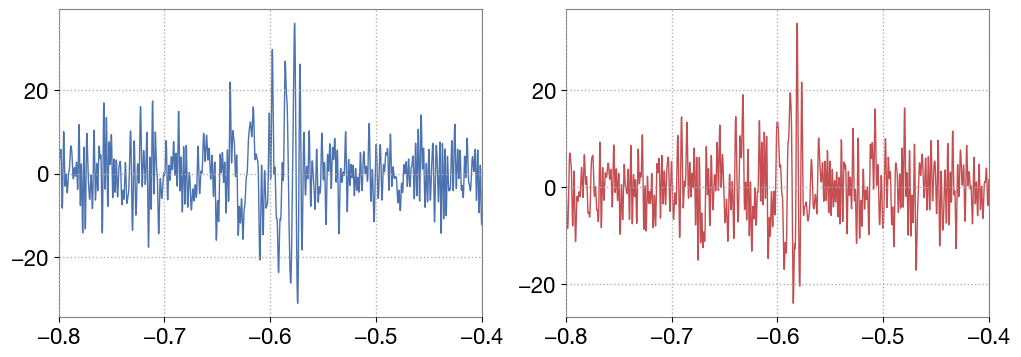

In [62]:
fig, axs = plt.subplots(1,2, figsize=[12,4])
axs[0].plot(times_d, strain_H1_td_wbp, c=colors[0])
axs[1].plot(times_d, strain_L1_td_wbp, c=colors[1])

for i in range(2):
    axs[i].set_xlim([-0.8, -0.4])

## Time-frequency visualizations: Q-transforms (pictures only !)

For Q-transforms, we refer to the tutorials 1.3 and 2.3 available at the GWOSC: [Gravitational-Wave Open Science Center (GWOSC)](https://www.gw-openscience.org).

### GW170814

The event in the three detectors H1, L1 and V1:

![Q-tranform near GW170814](images/GW170814_H1_qtransform.png)

![Q-tranform near GW170814](images/GW170814_L1_qtransform.png)

![Q-tranform near GW170814](images/GW170814_V1_qtransform.png)

And a glitch in the vicinity:

![Q-tranform near GW170814](images/GW170814_H1_glitch_qtransform.png)

![Q-tranform near GW170814](images/GW170814_L1_glitch_qtransform.png)

![Q-tranform near GW170814](images/GW170814_V1_glitch_qtransform.png)

### GW170817

H1 data for the BNS signal:

![Q-tranform near GW170817](images/GW170817_H1_qtransform.png)

L1 data for the BNS signal, affected by a large glitch:

![Q-tranform near GW170817](images/GW170817_L1_qtransform.png)

# Part III: matched filtering example with GW150914

## Data and template

The mass parameters (and distance, rescaled anyway) for the template were taken from here:

[GWOSC event page for GW150914](https://gwosc.org/eventapi/html/GWTC-1-confident/GW150914/v3/)

In [63]:
t_gps = event_gps('GW150914')
print(t_gps)

1126259462.4


In [64]:
H1_data = TimeSeries.read('./data/GW150914/H-H1_GWOSC_4KHZ_R1-1126259447-32.hdf5', format="hdf5.gwosc")
L1_data = TimeSeries.read('./data/GW150914/L-L1_GWOSC_4KHZ_R1-1126259447-32.hdf5', format="hdf5.gwosc")

In [65]:
# Allows to select a subest of data
# Here we use it all

# n = 2**np.round(np.log2(4. / dt))
n = len(times)
# mask_d = ( -n//2*dt <= time) & (time < n//2*dt)
mask_d = np.ones(n, dtype=bool)
times_d = times[mask_d]
strain_H1_d = strain_H1[mask_d]
strain_L1_d = strain_L1[mask_d]

n, n*dt, len(times_d), [times_d[0], times_d[-1]]

(131072, 32.0, 131072, [-16.0, 15.999755859375])

In [66]:
# Generate TD h2-2 template from best-guess masses
m1 = 34.6
m2 = 30.0
dist = 470.

template_hlm = gwsignal_GenerateTDModes(m1, m2, [0., 0., 0.], [0., 0., 0.], dist=dist, f_min=6., f_ref=100., f_nyquist=2048.)

t, template = template_hlm['t'], template_hlm[(2,-2)]

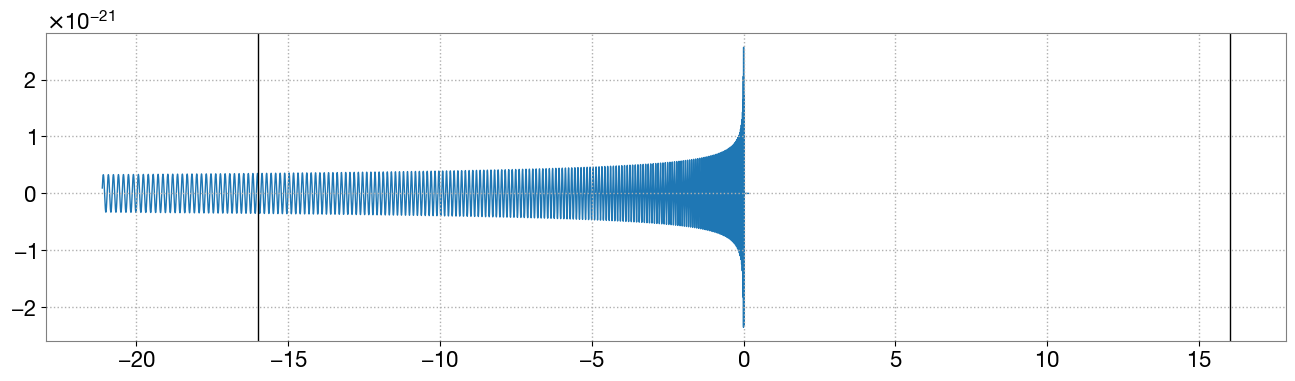

In [67]:
fig, ax = plt.subplots(1,1, figsize=[16,4])
ax.plot(t, np.real(template))
ax.axvline(times_d[0], c='k')
ax.axvline(times_d[-1], c='k')

In [68]:
# Template FD
# Tapering template at both ends
# Extend to the size of data
# Shift in time so that t=0 for template is at tpeak

# w_template = window_planck(t, t[0], t[-1], 0.5, 0.5)

template_d = np.zeros_like(strain_H1_d, dtype=complex)
# i0_template = np.argmin(np.abs(t))
# i0_data = np.argmin(np.abs(times_d))
istart_template = np.where(times_d[0] < t)[0][0]

mask_template = (times_d[0] < t)
mask_data = (times_d < t[-1])
template_d[mask_data] = template[mask_template]

w = window_planck(times_d, -8., 8., 2., 2.)

f, template_fd = fft_positivef(times_d, w * template_d)

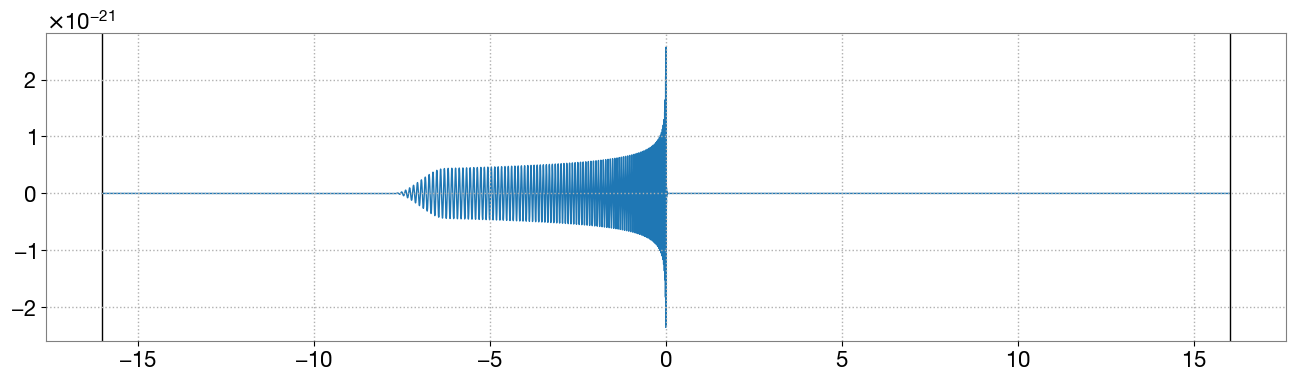

In [69]:
fig, ax = plt.subplots(1,1, figsize=[16,4])
ax.plot(times_d, np.real(w * template_d))
ax.axvline(times_d[0], c='k')
ax.axvline(times_d[-1], c='k')

(5.0, 2048.0)

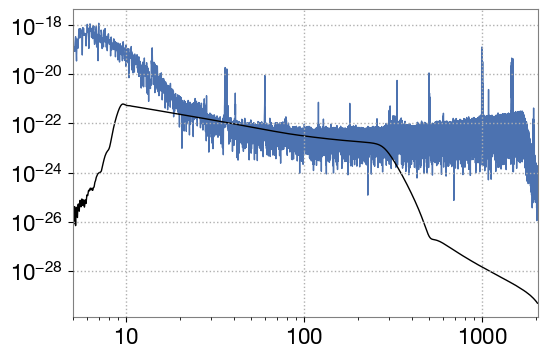

In [70]:
fig, ax = plt.subplots(1,1, figsize=[6,4])
ax.loglog(f_d, np.abs(strain_H1_fd), c=colors[0])
ax.loglog(f_d, np.abs(template_fd), c='k')

ax.set_xlim(5., 2048.)

## Matched filter

In [71]:
# Frequencies bounds for inner product
mask = (10. < f_d) & (f_d < 1024.)
w_fd = window_planck(f_d, 5., 1024., 5., 128.)

In [72]:
# Wiener filter formed with this template
W_H1_fd = w_fd * 2 / psd_H1_interp(f_d) * template_fd
W_L1_fd = w_fd * 2 / psd_L1_interp(f_d) * template_fd

In [73]:
# Normalization: N = (h|h)
# NOTE: the template does not include the instrument response, inclination, etc...
integrand_hh_H1 = w_fd * np.abs(template_fd)**2 / psd_H1_interp(f_d)
integrand_hh_L1 = w_fd * np.abs(template_fd)**2 / psd_L1_interp(f_d)
hh_H1 = 4*df * np.sum((integrand_hh_H1[1:] + integrand_hh_H1[:-1]) / 2)
hh_L1 = 4*df * np.sum((integrand_hh_L1[1:] + integrand_hh_L1[:-1]) / 2)
N_H1 = np.sqrt(hh_H1)
N_L1 = np.sqrt(hh_L1)
N_H1, N_L1

(97.4590945953429, 84.12624649884805)

In [74]:
# IFFT for time shifts
# Integrand: we compute (s|h) / sqrt((h|h)) = (s|h)/N with exp(+-2pi i f Deltat) (sign to check)
# NOTE: check the sign, here conjugation to make it work

# NOTE: factor 2 because we use ifft_positivef for a clearer impact of Deltaphi, but doing so we set negative frequencies to 0

integrand_H1 = w_fd * 1./N_H1 * (W_H1_fd) * np.conj(strain_H1_fd)
integrand_L1 = w_fd * 1./N_L1 * (W_L1_fd) * np.conj(strain_L1_fd)

t_ifft, ifft_H1 = ifft_positivef(f_d, np.conj(integrand_H1), real=True, tstart=times_d[0])
t_ifft, ifft_L1 = ifft_positivef(f_d, np.conj(integrand_L1), real=True, tstart=times_d[0])

# NOTE: mind the factor 2 here, because ifft_positivef sets negative frequencies to 0
t_ifft, ifft_H1_complex = ifft_positivef(f_d, np.conj(integrand_H1), real=False, tstart=times_d[0])
t_ifft, ifft_L1_complex = ifft_positivef(f_d, np.conj(integrand_L1), real=False, tstart=times_d[0])
ifft_H1_complex *= 2
ifft_L1_complex *= 2

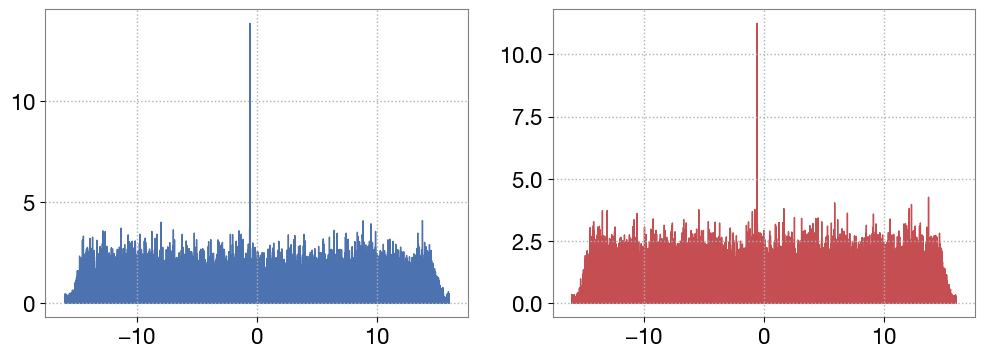

In [75]:
# NOTE: this shows \rho optimized over phase shift, for different times shifts

fig, axs = plt.subplots(1,2, figsize=[12,4])
axs[0].plot(times_d, np.abs(ifft_H1), c=colors[0])
axs[1].plot(times_d, np.abs(ifft_L1), c=colors[1])

Text(0.5, 0, 'rho')

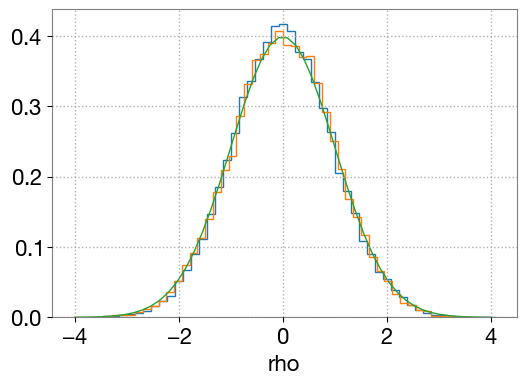

In [76]:
mask_test = (0. <= times_d) & (times_d <= 12.)

fig, ax = plt.subplots(1,1, figsize=[6,4])
ax.hist(ifft_H1[mask_test], histtype='step', density=True);
ax.hist(ifft_L1[mask_test], histtype='step', density=True);
x_plt = np.linspace(-4., 4.)
ax.plot(x_plt, 1./np.sqrt(2*np.pi) * np.exp(-1./2 * x_plt**2))

ax.set_xlabel(r'rho')

In [77]:
alpha_td = np.arctan2(np.imag(ifft_H1_complex), np.real(ifft_H1_complex))
A_td = np.abs(ifft_H1_complex) / N_H1

rho = np.abs(ifft_H1_complex)
iopt = np.argmax(rho)
A_opt = A_td[iopt]
alpha_opt = alpha_td[iopt]
Deltat_opt = times_d[iopt]

In [78]:
A_opt, alpha_opt, Deltat_opt

(0.16702997694490554, 1.8179571352557684, -0.57470703125)

In [79]:
freq_fft = f_d
mask_ext = (5. < freq_fft) & (freq_fft < 1024.)
freq_ext = freq_fft[mask_ext]

def htemplate_wbp_td(A, Deltat, alpha):
    w_ifft = window_planck(freq_ext, 5., 1024., 5., 128.)
    h_fd = np.zeros_like(f_d, dtype=complex)
    h_fd[mask_ext] = w_ifft * A * np.exp(1j*alpha) * np.exp(-2*1j*np.pi*freq_fft[mask_ext]*Deltat) * template_fd[mask_ext]
    h_wbp_fd =  np.sqrt((2 * df) / psd_H1_interp(freq_fft)) * h_fd 
    return ifft_positivef(freq_fft, h_wbp_fd, real=True, tstart=times_d[0])

In [80]:
_, ht_wbp_opt = htemplate_wbp_td(A_opt, Deltat_opt, alpha_opt)

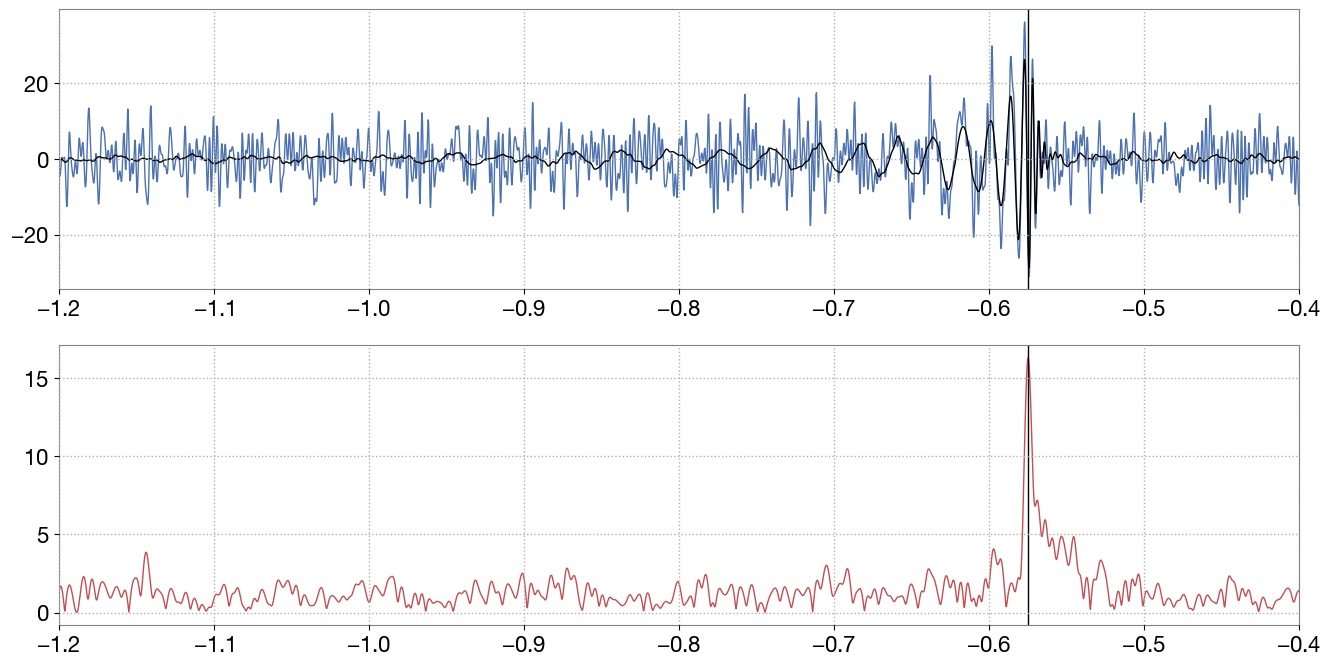

In [81]:
fig, axs = plt.subplots(2,1, figsize=[16,8])
axs[0].plot(times_d, strain_H1_td_wbp, c=colors[0])
axs[0].plot(times_d, ht_wbp_opt, c='k')
axs[1].plot(times_d, rho, c=colors[1])

for i in range(2):
    axs[i].set_xlim([-1.2, -0.4])
    axs[i].axvline(Deltat_opt, c='k', lw=1.)